In [1]:
import os

os.chdir('./code')

In [2]:
import os

# 현재 작업 디렉토리 확인
current_directory = os.getcwd()
print(f"현재 작업 디렉토리: {current_directory}")

현재 작업 디렉토리: /Users/delaykimm/Desktop/DAIS/코드(project)/TEST_code/code


In [ ]:
#%run ucr.py --dataset 'ElectricDevices' --path '../' --save_path './models/' --prototype_file 'gpt2_prototype/text_prototype_random.pt' --hyper "models/ElectricDevices_hyperparameters.json"
%run ucr.py --dataset 'ElectricDevices' --path '../' --save_path './models/' --prototype_file 'gpt2_prototype/text_prototype_representative.pt' --hyper "models/ElectricDevices_hyperparameters.json"

/Users/delaykimm/Desktop/DAIS/코드(project)/TEST_code/.conda/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Loading GPT-2 model: gpt2


/Users/delaykimm/Desktop/DAIS/코드(project)/TEST_code/.conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


----Select 10 random text prototypes----


AssertionError: Torch not compiled with CUDA enabled

In [5]:
print(torch.cuda.is_available())  # True가 출력되면 GPU를 사용할 수 있음

False


[[[-0.21694957  0.44539325 -0.392389   ...  2.64293572  0.54012303
    2.29046707]
  [ 1.60026782 -0.18883478 -0.41227175 ...  0.50481546  1.30318096
    0.12853632]
  [-0.14244787 -1.30876351 -1.20247531 ...  0.09152195  1.05343975
   -0.56340766]
  ...
  [-0.07616856 -1.65249333 -1.85910821 ...  0.37761266  2.02969903
    0.63240765]
  [ 0.35894322  0.44968757 -0.30584564 ...  1.3139348   0.3545247
    1.67568179]
  [-0.45989552  0.09686959  0.90120831 ...  1.19779556 -1.59373823
   -0.79251334]]

 [[-0.62214668 -1.65976109  0.43504473 ...  0.6632405  -0.1334914
   -1.56637034]
  [-1.74865144 -1.12259194  0.79855081 ...  1.00997296 -0.75263121
    0.081016  ]
  [ 0.56162102 -0.41273318  0.13252728 ... -0.10522217  0.49465332
    1.30444939]
  ...
  [ 0.33974529 -0.5536059   0.18571425 ...  0.01546627  0.80818638
    0.14445854]
  [ 0.48382447  0.40029396 -1.85774296 ...  0.16368304  0.93602582
   -0.76652874]
  [ 0.58420795  1.23091659 -0.83028615 ...  0.70312324 -0.03932824
   -0.93

/tmp/ipykernel_1012583/1897567368.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_labels))


8
Current embedding shape: (11, 768)
After embedding shape: (11, 768)
8


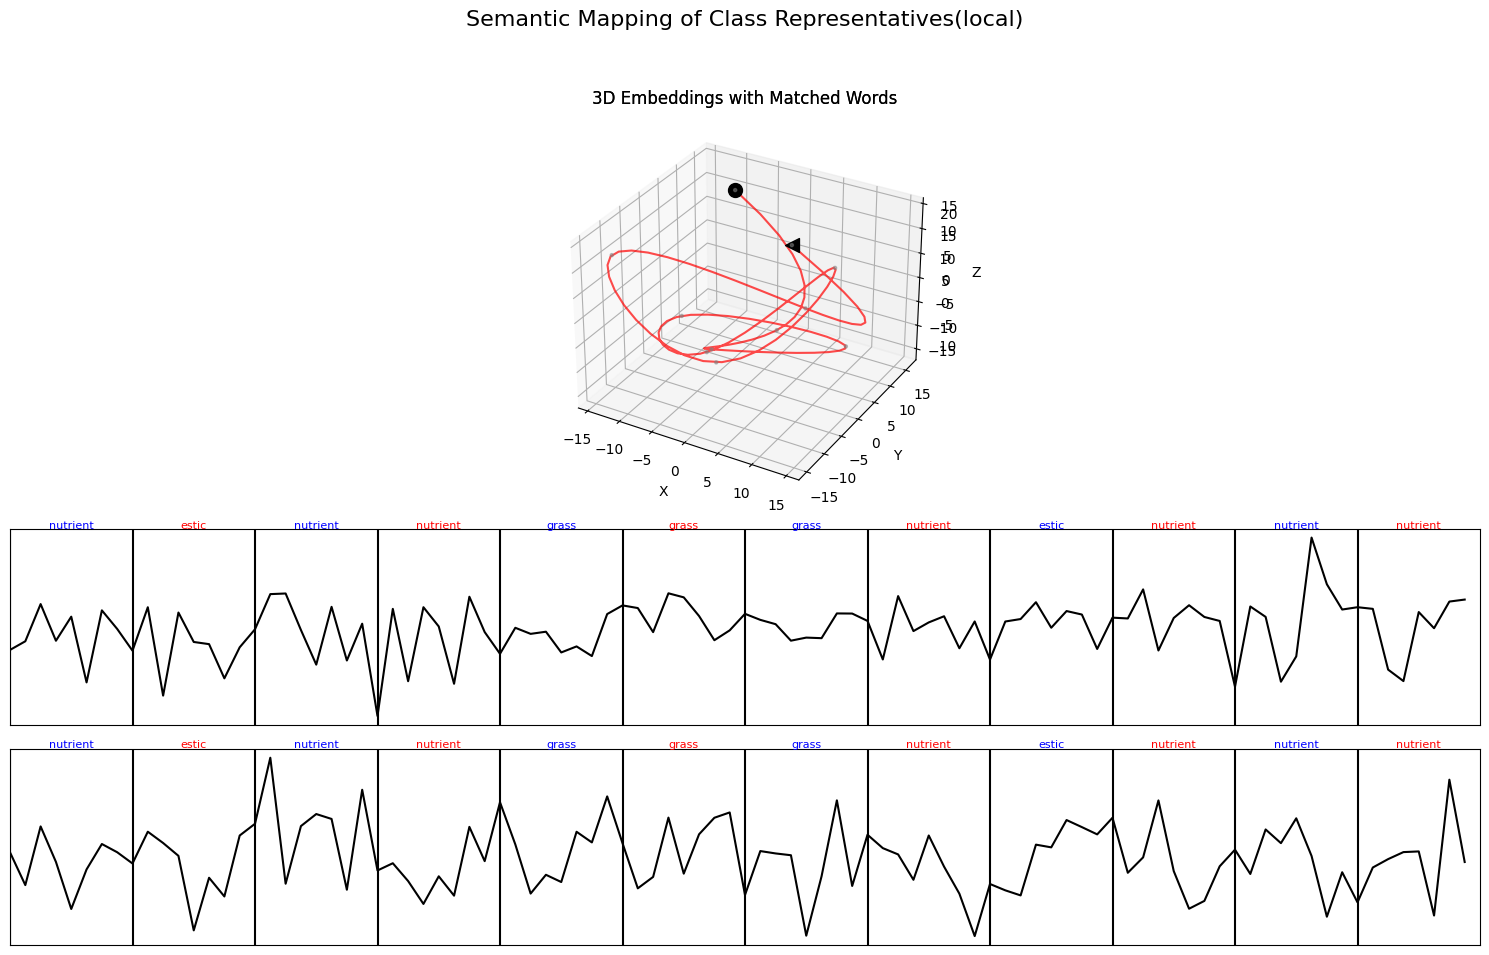

In [29]:
import numpy
import torch

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import make_interp_spline

def semantic_matching(embeddings, X, labels, title="Matching TS Embedding to Words", save_path='./visualization_semantic/semantic_matching.png'):
    """
    시계열 데이터의 구간별 임베딩을 시각화하고 가장 가까운 단어와 매칭하여 표시합니다.
    
    @param embeddings: 구간별 임베딩 벡터 (features 또는 features_from_llm)
    @param X: 원본 시계열 데이터
    @param labels: 클래스 라벨
    @param title: 그래프 제목
    @param save_path: 저장 경로
    """
    
    # 텐서를 numpy 배열로 변환
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.cpu().numpy()
    if isinstance(X, torch.Tensor):
        X = X.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    
    # 클래스당 하나의 대표 시계열 선택
    unique_labels = numpy.unique(labels)
    selected_embeddings = []
    selected_timeseries = []
    selected_labels = []
    
    for label in unique_labels:
        label_indices = numpy.where(labels == label)[0]
        selected_idx = label_indices[0]  # 각 클래스의 첫 번째 샘플 선택
        selected_embeddings.append(embeddings[selected_idx])
        selected_timeseries.append(X[selected_idx])
        selected_labels.append(label)
    
    selected_embeddings = numpy.array(selected_embeddings)
    selected_timeseries = numpy.array(selected_timeseries)
    
    print("Embeddings shape before processing:", embeddings.shape)
    print("Selected embeddings shape:", selected_embeddings[0].shape, selected_embeddings.shape)
    
    # 시각화를 위한 figure 설정
    num_rows = selected_embeddings.shape[0]  # 동적 행 개수 설정
    print(num_rows)
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(num_rows+1, 1, height_ratios=[2] + [1] * num_rows, figure=fig)
    fig.suptitle(title, fontsize=16)

    matched_words_all = []  # 전체 매칭 단어 저장
    
    # 색상 맵핑 설정
    color_map = plt.cm.get_cmap('tab10', len(unique_labels))
    
    # 각 시계열의 구간별 임베딩에 대해 처리
    for idx, (embedding, timeseries, label) in enumerate(zip(selected_embeddings, selected_timeseries, selected_labels)):
        # # 구간별 임베딩을 2D로 축소
        # print("Shape before PCA:", embedding.shape)

        # if embedding.ndim == 1:
        #     embedding = embedding.reshape(1, -1)
        
        # pca = PCA(n_components=3)
        # reduced_embeddings = pca.fit_transform(embedding)
        # 데이터 shape 확인
        
        print("Current embedding shape:", embedding.shape)
        
        # 데이터 reshape
        if embedding.ndim == 1:
            embedding = embedding.reshape(-1, 768)
        elif embedding.ndim == 3:
            embedding = embedding.reshape(embedding.shape[0], -1)
            
        # Perform PCA to reduce embeddings to 3D
        pca = PCA(n_components=3)
        reduced_embedding = pca.fit_transform(embedding)
        
        print("After embedding shape:", embedding.shape)
        
        # # Initialize plot
        # fig = plt.figure(figsize=(12, 14))
        # gs = GridSpec(3, 1, height_ratios=[2, 1, 1], figure=fig)
        # fig.suptitle(title, fontsize=16)
        
        # 3D plot of embeddings
        ax_main = fig.add_subplot(gs[0], projection='3d')
        ax_main.scatter(reduced_embedding[:, 0], reduced_embedding[:, 1], reduced_embedding[:, 2], s=5, color='gray', alpha=0.5)
        
        # Match words to each embedding segment and plot
        matched_words = []
        path_points = []

        for i in range(embedding.shape[0]):
            #similarities = cosine_similarity(embedding[i].reshape(1, -1), vocab_embeddings)[0]
            #closest_word = self.vocab_words[numpy.argmax(similarities)]
            #matched_words.append(closest_word)
            path_points.append(reduced_embedding[i])
            
            # Display each word at its 3D position
            #ax_main.text(reduced_embedding[i, 0], reduced_embedding[i, 1], reduced_embedding[i, 2], 
            #            closest_word, fontsize=8, color="black")
        
        #matched_words_all.append(matched_words) # 전체 매칭 단어에 추가
        
        # Draw path connecting words in the order they appear
        path_points = numpy.array(path_points)
        
        # 부드러운 곡선 경로를 위해 스플라인 보간
        t = numpy.linspace(0, 1, len(path_points))
        spl = make_interp_spline(t, path_points, k=3)  # 3차 스플라인 보간
        t_fine = numpy.linspace(0, 1, 100)
        smooth_path = spl(t_fine)

        # 경로 그리기 (부드러운 곡선)
        ax_main.plot(smooth_path[:, 0], smooth_path[:, 1], smooth_path[:, 2], color="red", alpha=0.7)
        
        # 시작점과 끝점에만 표시
        start = path_points[0]
        end = path_points[-1]
        ax_main.scatter(*start, color='black', s=100, marker="<")      # 시작 지점에 화살표
        ax_main.scatter(*end, color='black', s=100, label="End")       # 끝 지점에 동그라미
        
        ax_main.set_title("3D Embeddings with Matched Words")
        ax_main.grid(True)   # 3D 그리드 활성화
        ax_main.axis('on')
        
        # 하단에 원시 시계열 데이터와 매칭된 단어 시각화
        ax_timeseries = fig.add_subplot(gs[1 + idx])
        # x축을 0부터 시계열 데이터 길이까지 생성하여, 시작점에서 시각화가 시작되도록 함
        x_values = range(len(timeseries))
        ax_timeseries.plot(x_values, timeseries, color="black")
        
        ax_timeseries.set_xticks([])
        ax_timeseries.set_yticks([])

        matched_words = ["nutrient", "estic", "nutrient", "nutrient", "grass", "grass", "grass", "nutrient", "estic", "nutrient", "nutrient", "nutrient"]

        # 각 구간에 해당하는 단어 표시
        segment_length = len(timeseries) // len(matched_words)
        print(segment_length)
        for j, word in enumerate(matched_words):
            # 각 구간의 중앙에 단어를 표시
            start_idx = j * segment_length
            end_idx = start_idx + segment_length
            segment_center = (start_idx + end_idx) // 2
            
            # 단어를 박스 상단에 표시
            ax_timeseries.text(segment_center, numpy.max(timeseries) + 0.1 * numpy.abs(numpy.max(timeseries)), word, 
                            fontsize=8, ha="center", color="blue" if j % 2 == 0 else "red")  # 색상 교차

            # 박스 경계선 그리기
            ax_timeseries.axvline(x=start_idx, color="black", linestyle="-")  # 박스 시작선
            
            # x축 제한 설정 (시계열 데이터를 각 박스에 꽉 차도록 표시)
        ax_timeseries.set_xlim(0, len(timeseries))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # 축 레이블 설정
    ax_main.set_xlabel("X")
    ax_main.set_ylabel("Y")
    ax_main.set_zlabel("Z")

    # # Save the visualization
    # if save_path:
    #     os.makedirs(os.path.dirname(save_path), exist_ok=True)
    #     plt.savefig(save_path)
    #     print(f"Plot saved to: {save_path}")
    
    plt.show()
    plt.close()
    
    return matched_words

random_data = numpy.random.randn(5, 11, 768)
random_series = numpy.random.randn(5, 96)
print(random_data) 
numpy.random.seed(0)
embedding = numpy.random.randn(100, 3)  # 100개의 점을 임의로 생성

y = [1,2]  
matched_dict_local = semantic_matching(
            embeddings=random_data,  # 또는 features
            X = random_series, # 원본 시계열 데이터
            labels=y,  # 클래스 레이블
            title="Semantic Mapping of Class Representatives(local)",
            save_path='../visualization_semantic/class_representatives(local).png'
        )